Downloading the dependices

In [41]:
!pip install -q -U git+https://github.com/lvwerra/trl.git
!pip install -q -U bitsandbytes
!pip install -U -q git+https://github.com/huggingface/transformers@de9255de27abfcae4a1f816b904915f0b1e23cd9
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U sentencepiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Downloading datasets

In [42]:
from datasets import load_dataset
dbricks_15k_dataset_base = load_dataset("databricks/databricks-dolly-15k")

In [43]:
dbricks_15k_dataset_base

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

plotting the sequence length of the data---->so that we can drop the larger examples

In [44]:
import matplotlib.pyplot as plt
from datasets import load_dataset

def plot_sequence_lengths(dataset_obj):
    sequence_lengths = []
    too_long = []# a list of too long sentences

    # Loop over the dataset and get the lengths of text sequences
    for idx, example in enumerate(dataset_obj["train"]):
        sequence_lengths.append(len(example['instruction']) + len(example["context"]) + len(example["response"]))
        if sequence_lengths[idx] > 2200:
          too_long.append(idx)#to keep track of index of too long sentences

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return too_long

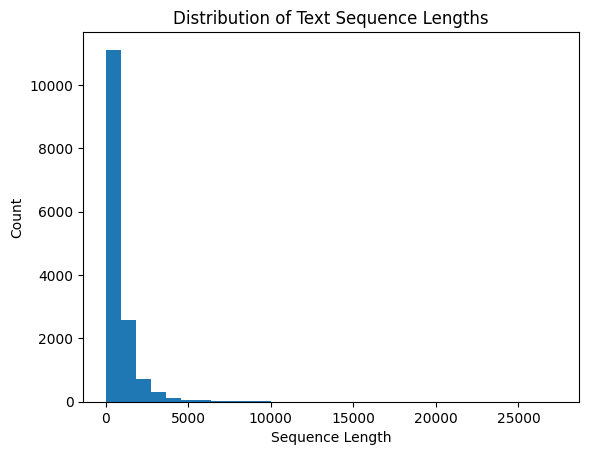

In [45]:
index_to_drop = plot_sequence_lengths(dbricks_15k_dataset_base)

In [46]:
len(index_to_drop)# have to drop these indexes

936

In [47]:
dbricks_reduced = dbricks_15k_dataset_base["train"].select(
    i for i in range(len(dbricks_15k_dataset_base["train"])) if i not in set(index_to_drop)
)

In [48]:
dbricks_reduced #no train test split here

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 14075
})

Train test split on reduced dataset

In [49]:
dbricks_final = dbricks_reduced.train_test_split(test_size=0.1)

In [50]:
dbricks_final

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1408
    })
})

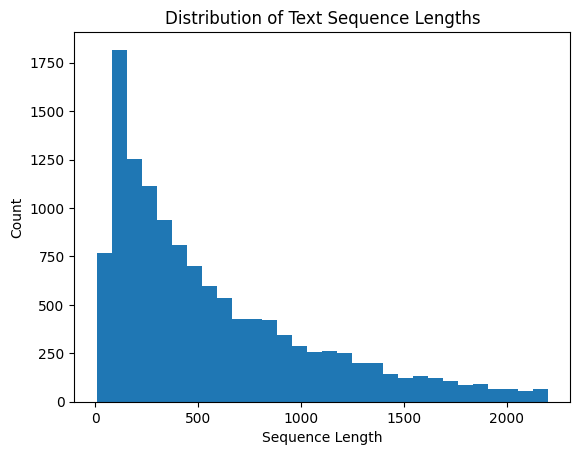

In [51]:
index_= plot_sequence_lengths(dbricks_final)

Formatting the training dataset ->like how it will be presented to the model while training

In [52]:
def format(example):
  if example.get("context", "") != "":
      input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Input: \n"
      f"{example['context']}\n\n"
      f"### Response: \n"
      f"{example['response']}")

  else:
    input_prompt = (f"Below is an instruction that describes a task. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Response:\n"
      f"{example['response']}")

  return {"text" : input_prompt}

In [53]:
#below is the diff between the formatted and non formatted example
sample1=dbricks_final['train'][0]
print(sample1)
print('-------------------------------------')
format_sample1=format(sample1)
print(format_sample1)

{'instruction': 'How would you train for a marathon?', 'context': '', 'response': "If you are not regularly running, but are generally fit, it would require many months of training to complete a marathon. Running at least 3 or better 4 times a week will be necessary. You should gradually increase your training load. A good guidance is to not increase the total mileage by more than 10% per week. One of the weekly runs should be a long run. You can should start with a distance that you are able to currently run, and keep gradually increasing it every week until you are able to run 30 km. You shouldn't need training runs longer than that. You should be able to run 30 km about 6 weeks before your target marathon. In the last weeks before the marathon decrease it down to about 20 km. The other runs in the week should be shorter. You should start as short as you are comfortable, and then increase them until they are 10-12 km. You should run all these runs at an easy pace, that would allow yo

In [54]:
format_dataset = dbricks_final.map(format)

Map:   0%|          | 0/12667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

In [55]:
format_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 1408
    })
})

In [56]:
format_dataset['train'][0]

{'instruction': 'How would you train for a marathon?',
 'context': '',
 'response': "If you are not regularly running, but are generally fit, it would require many months of training to complete a marathon. Running at least 3 or better 4 times a week will be necessary. You should gradually increase your training load. A good guidance is to not increase the total mileage by more than 10% per week. One of the weekly runs should be a long run. You can should start with a distance that you are able to currently run, and keep gradually increasing it every week until you are able to run 30 km. You shouldn't need training runs longer than that. You should be able to run 30 km about 6 weeks before your target marathon. In the last weeks before the marathon decrease it down to about 20 km. The other runs in the week should be shorter. You should start as short as you are comfortable, and then increase them until they are 10-12 km. You should run all these runs at an easy pace, that would allow 

downloading model
and setting up lora and tokenizer

In [ ]:
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

model_id = "openlm-research/open_llama_7b" #model name on hugging face

qlora_config = LoraConfig(
    #hyperparameters for finetuning using qlora -> based on original repo of this model and other repo using this
    r=16, #rank of matrix 100x100-> 100x16 and 16x100  16 is default value
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
#in order to add qunatisation to the model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,#32bit to 4bit integers to keep value small so that it can be trained
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
)

In [ ]:
from transformers import LlamaTokenizer
#downloading the tokenizer for lamma model
tokenizer = LlamaTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

In [ ]:
print(base_model) #all are in 4 bit

Training the model

In [ ]:
from trl import SFTTrainer

supervised_finetuning_trainer = SFTTrainer(
    base_model,
    train_dataset=format_dataset["train"],
    eval_dataset=format_dataset["test"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        max_steps=1000,
        output_dir="./SFTOpenLM-Dolly15k",
        optim="paged_adamw_8bit",
        fp16=True,
    ),
    tokenizer=tokenizer,
    peft_config=qlora_config,
    dataset_text_field="text",
    max_seq_length=512
)

In [ ]:
supervised_finetuning_trainer.train()

Testing model

In [ ]:
from IPython.display import display, Markdown

def make_inference(instruction, context = None):
  if context:
    prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
  else:
    prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
  inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
  outputs = base_model.generate(**inputs, max_new_tokens=100)
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))

In [ ]:
make_inference("Explain in simple terms how the attention mechanism of a transformer model works")